In this Project I used ResNet-50  convolutional neural network Architecture for Classifying Military Aircraft 

I used functional API. It is a way to create models that are more flexible than Sequential API. 

In [ ]:
# pip install opendatasets --upgrade --quiet

In [ ]:
# pip install split_folders

In [ ]:
# import the libraries as shown below
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from glob import glob
import pathlib
import tensorflow as tf
import cv2, os, random
from termcolor import colored
from tensorflow.keras.utils import image_dataset_from_directory, plot_model
from tensorflow.keras import layers, losses, optimizers, applications
from warnings import filterwarnings
filterwarnings("ignore")
from sklearn import set_config
set_config(print_changed_only = False)
import splitfolders

In [ ]:
# importing dataset from kaggle 
import opendatasets as od
dataset_url="https://www.kaggle.com/datasets/a2015003713/militaryaircraftdetectiondataset"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abisusikavin
Your Kaggle Key: ··········


100%|██████████| 9.22G/9.22G [01:10<00:00, 141MB/s]


In [ ]:
# Data partitioning into train and validation
input_folder = "/content/militaryaircraftdetectiondataset/crop"
output = "/content/Dataset" 

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.9, .1))

Copying files: 16676 files [00:08, 1893.41 files/s]


In [ ]:
train_path = "/content/Dataset/train"
path_for_train_data = pathlib.Path(train_path)

valid_path = "/content/Dataset/val"
path_for_valid_data = pathlib.Path(valid_path)

In [ ]:
train_df = image_dataset_from_directory(path_for_train_data,
                                        image_size = (128, 128),
                                        validation_split = 0.3,
                                        subset = "training",
                                        shuffle = True,
                                        batch_size = 25,
                                        seed = 123)

validation_df = image_dataset_from_directory(path_for_valid_data,
                                             image_size = (128, 128),
                                             validation_split = 0.35,
                                             subset = "validation",
                                             shuffle = True,                                         
                                             batch_size = 25,
                                             seed = 123)

Found 14992 files belonging to 41 classes.
Using 10495 files for training.
Found 1684 files belonging to 41 classes.
Using 589 files for validation.


In [ ]:
train_df, validation_df

(<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [ ]:
print("There is {} images in the training dataset".format(len(train_df)))
print("There is {} images in the validation dataset".format(len(validation_df)))

There is 420 images in the training dataset
There is 24 images in the validation dataset


In [ ]:
folders = glob('/content/militaryaircraftdetectiondataset/crop/*')
len(folders)

41

In [ ]:
folders

['/content/militaryaircraftdetectiondataset/crop/F16',
 '/content/militaryaircraftdetectiondataset/crop/F117',
 '/content/militaryaircraftdetectiondataset/crop/F35',
 '/content/militaryaircraftdetectiondataset/crop/C2',
 '/content/militaryaircraftdetectiondataset/crop/AG600',
 '/content/militaryaircraftdetectiondataset/crop/YF23',
 '/content/militaryaircraftdetectiondataset/crop/Su34',
 '/content/militaryaircraftdetectiondataset/crop/AV8B',
 '/content/militaryaircraftdetectiondataset/crop/F14',
 '/content/militaryaircraftdetectiondataset/crop/V22',
 '/content/militaryaircraftdetectiondataset/crop/US2',
 '/content/militaryaircraftdetectiondataset/crop/F18',
 '/content/militaryaircraftdetectiondataset/crop/Tu160',
 '/content/militaryaircraftdetectiondataset/crop/Su57',
 '/content/militaryaircraftdetectiondataset/crop/Vulcan',
 '/content/militaryaircraftdetectiondataset/crop/Mig31',
 '/content/militaryaircraftdetectiondataset/crop/B52',
 '/content/militaryaircraftdetectiondataset/crop/B1'

In [ ]:
class_names =['F16','F117','F35','C2','AG600','YF23','Su34','AV8B','F14','V22','US2','F18','Tu160',
              'Su57','Vulcan','Mig31','B52','B1','J20','F15','E2','F22','Be200','XB70','A400M','Mirage2000',
              'JAS39','EF2000','MQ9','C17','SR71','U2','A10','RQ4','Rafale','Tornado','Tu95','C130','B2','C5','F4q']

In [ ]:
len(class_names)

41

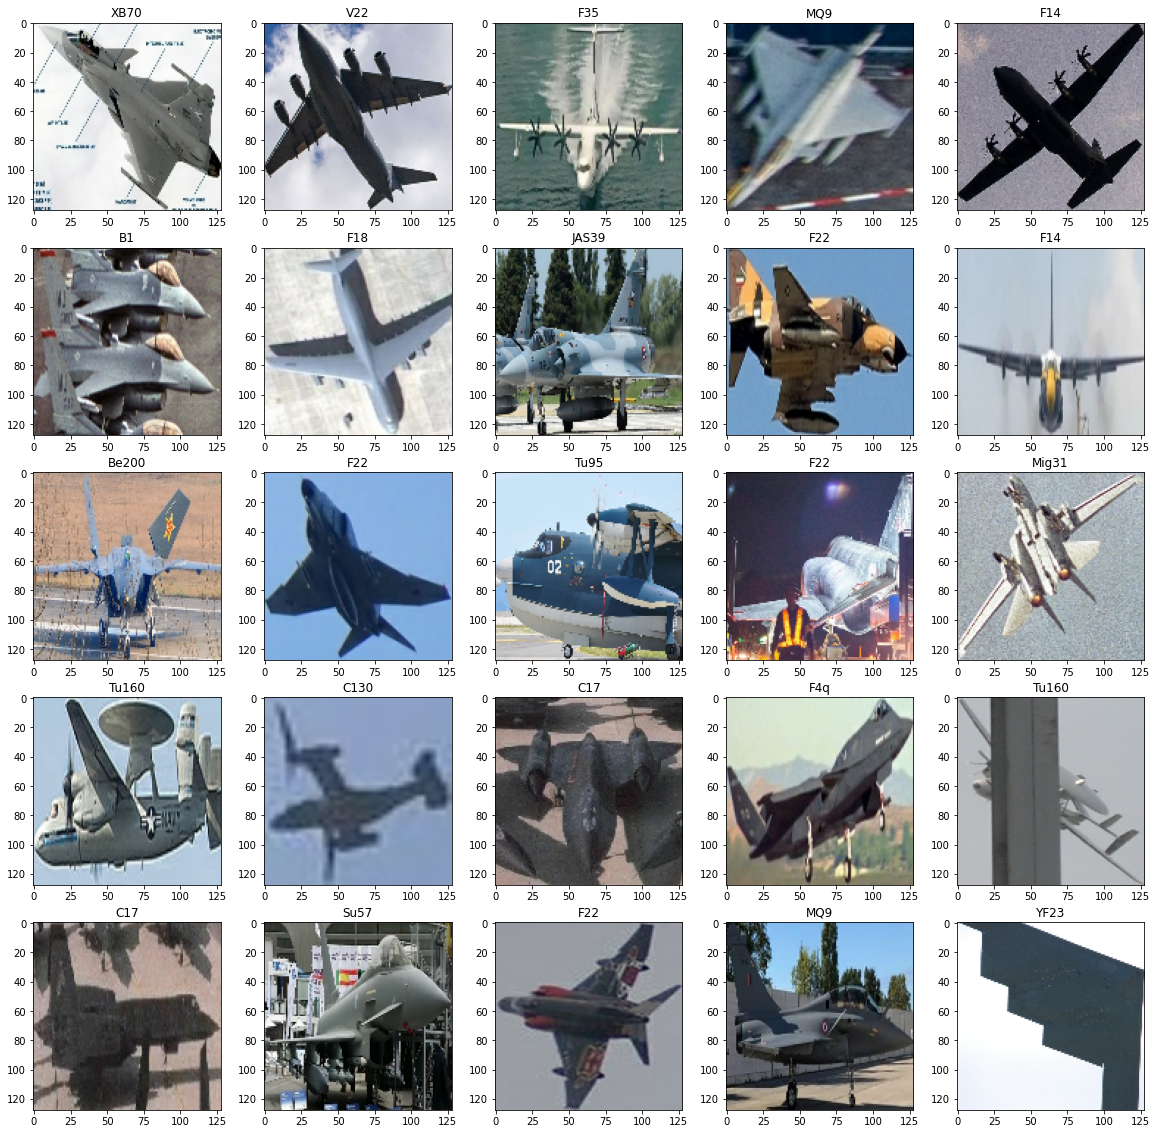

In [ ]:
# class_names = path_for_train_data.class_names

plt.figure(figsize = (20, 20))
for images, labels in train_df.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])

In [ ]:
validation_batches = tf.data.experimental.cardinality(validation_df)
validation_batches

<tf.Tensor: shape=(), dtype=int64, numpy=24>

In [ ]:
# take validation batches for test set
test_df = validation_df.take(validation_batches // 5)

# skip validation batches for validation set
validation_df = validation_df.skip(validation_batches // 5)

test_df, validation_df

(<TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <SkipDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [ ]:
autotune = tf.data.AUTOTUNE

In [ ]:
pf_train = train_df.prefetch(buffer_size = autotune)

In [ ]:
pf_test = test_df.prefetch(buffer_size = autotune)

In [ ]:
pf_val = validation_df.prefetch(buffer_size = autotune)

In [ ]:
# Layer for data augmentation
data_augmentation = tf.keras.Sequential()
data_augmentation.add(layers.RandomRotation(0.3))
data_augmentation.add(layers.RandomFlip("horizontal_and_vertical"))

In [ ]:
# basic setup
image_size = (128, 128)
image_shape = image_size + (3,)

In [ ]:
# input processing
preprocess_input = applications.resnet50.preprocess_input

In [ ]:
# base model (ResNet50)
base_model = applications.ResNet50(input_shape = image_shape, include_top = False, weights = 'imagenet')

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# freeze layers
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

In [ ]:
# Layers for classification
nclass = len(class_names)
global_avg = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(nclass, activation = 'softmax')

In [ ]:
inputs = tf.keras.Input(shape = image_shape)
x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x)
x = global_avg(x)
outputs = output_layer(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 41)                84009 

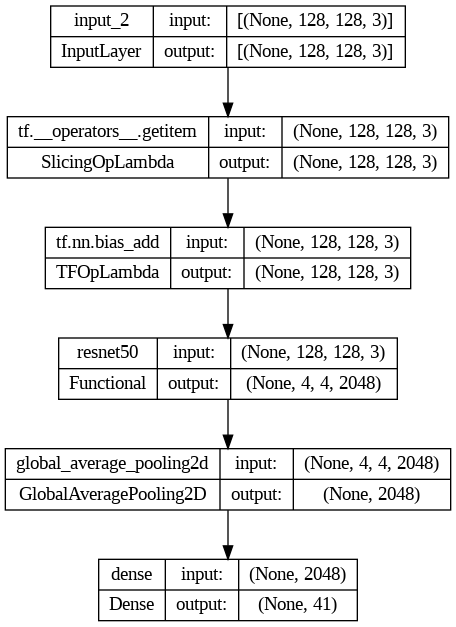

In [ ]:
image_file = '/content/model_plot.png'
plot_model(model, to_file = image_file, show_shapes = True)

In [ ]:
optimizer = optimizers.Adam(learning_rate = optimizers.schedules.CosineDecay(0.001, 500))
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

In [ ]:
# Train the model 
history = model.fit(pf_train, validation_data = (pf_val), epochs = 1)

420/420 [==============================] - 716s 2s/step - loss: 2.8218 - accuracy: 0.3088 - val_loss: 2.0995 - val_accuracy: 0.4172


In [ ]:
# Tuning the model
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [ ]:
optimizer = optimizers.RMSprop(learning_rate = optimizers.schedules.CosineDecay(0.001, 500))
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

In [ ]:
ft_epoch = 1
n_epochs =+ ft_epoch
history_fine = model.fit(pf_train, validation_data = (pf_val), epochs = 5, initial_epoch = history.epoch[-1])

Epoch 1/5
420/420 [==============================] - 1859s 4s/step - loss: 0.3310 - accuracy: 0.9266 - val_loss: 0.8983 - val_accuracy: 0.7669
Epoch 2/5
420/420 [==============================] - 1821s 4s/step - loss: 0.3097 - accuracy: 0.9383 - val_loss: 0.9126 - val_accuracy: 0.7648
Epoch 3/5
420/420 [==============================] - 1814s 4s/step - loss: 0.3098 - accuracy: 0.9384 - val_loss: 0.9315 - val_accuracy: 0.7566
Epoch 4/5
420/420 [==============================] - 1817s 4s/step - loss: 0.3065 - accuracy: 0.9404 - val_loss: 0.9149 - val_accuracy: 0.7587
Epoch 5/5
420/420 [==============================] - 1809s 4s/step - loss: 0.3116 - accuracy: 0.9380 - val_loss: 0.9737 - val_accuracy: 0.7342


In [ ]:
# Make predictions using trained model 
image_batch, label_batch = pf_test.as_numpy_iterator().next()
pred_labels = np.argmax(model.predict(image_batch), axis = 1)

1/1 [==============================] - 3s 3s/step


In [ ]:
lab_and_pred = np.transpose(np.vstack((label_batch, pred_labels)))
print(lab_and_pred)

[[36 36]
 [16 16]
 [31 31]
 [14 14]
 [ 5  5]
 [17 17]
 [ 7  7]
 [26 29]
 [36 36]
 [ 5 19]
 [13 17]
 [27 27]
 [18 18]
 [23 28]
 [ 5  5]
 [ 4 33]
 [36 36]
 [ 3  3]
 [11 11]
 [25 25]
 [10 11]
 [35 35]
 [19 19]
 [18 13]
 [34 12]]


This Model Performing well on identifying the aircraft